In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import shapiro
from sklearn import preprocessing
from helpers import OutlierDetection,boxplotter
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif 

import pickle

churn=pd.read_csv('telco-customer_churn.csv')

## Basic Information Pulls

In [2]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
churn.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


We see that although TotalCharges is a float, it is listed as an object. In order to better organize our variables, we need to convert it to a float and handle blank entries. I can strip the empty space and replace it with NaN variables.

In [5]:
churn['TotalCharges']=churn['TotalCharges'].str.strip()

TotalCharges
          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: count, Length: 6531, dtype: int64


In [6]:
churn['TotalCharges']=churn['TotalCharges'].replace(' ',np.nan)
churn['TotalCharges']=churn['TotalCharges'].replace('',np.nan)


In instances where the TotalCharges value is NaN, replace with MonthlyCharges * tenure to get a rough estimation of expenses.

In [7]:
def totalimputer(row):
    if pd.isna(row['TotalCharges']):
        return row['tenure'] * row['MonthlyCharges']
    else:
        return row['TotalCharges']
    
churn['TotalCharges']=churn.apply(totalimputer, axis=1)

In [8]:
churn.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
churn.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [10]:
print(f"Dataset Shape: {churn.shape[0]} rows, {churn.shape[1]} cols")

Dataset Shape: 7043 rows, 21 cols


In [11]:
churn['TotalCharges']=churn['TotalCharges'].astype(np.float64)

Convert Senior Citizen to Categorical for the purposes of univariate analysis. It will return to a numerical variable later on when we label encode the categoricals.

In [12]:
def senior_convert(row):
    if row['SeniorCitizen']==0:
        return 'No'
    elif row['SeniorCitizen']==1:
        return 'Yes'
    
churn['SeniorCitizen']=churn.apply(senior_convert, axis=1)
churn['SeniorCitizen']=churn['SeniorCitizen'].astype(str)

In [13]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Finding Outliers within Numerical Variables

In [14]:
non_normalized=churn[['TotalCharges','MonthlyCharges','tenure']].copy(deep=True)

We see not outliers in the initial boxplot, but let's run IQR to make sure.

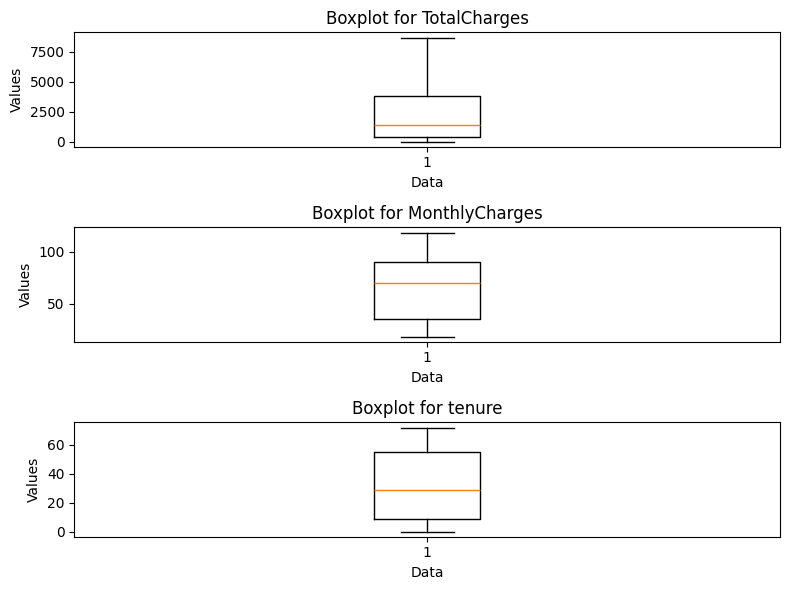

In [15]:
boxplotter(non_normalized)

Find the helper function in helpers.py

In [16]:
OutlierDetection(non_normalized)



,TotalCharges,MonthlyCharges,tenure
0,29.85,29.85,1
1,1889.50,56.95,34
2,108.15,53.85,2
3,1840.75,42.30,45
4,151.65,70.70,2
...,...,...,...
7038,1990.50,84.80,24
7039,7362.90,103.20,72
7040,346.45,29.60,11
7041,306.60,74.40,4


## Bar Charts for Boolean and Categorical Variables

In [17]:
categorical=churn.select_dtypes(include=['object'])
numerical=churn.select_dtypes(exclude=['object'])
categorical.drop(columns='customerID', inplace=True)

I notice very few senior citizens, and very few customers with no phone service. that data will be handled during feature selection.

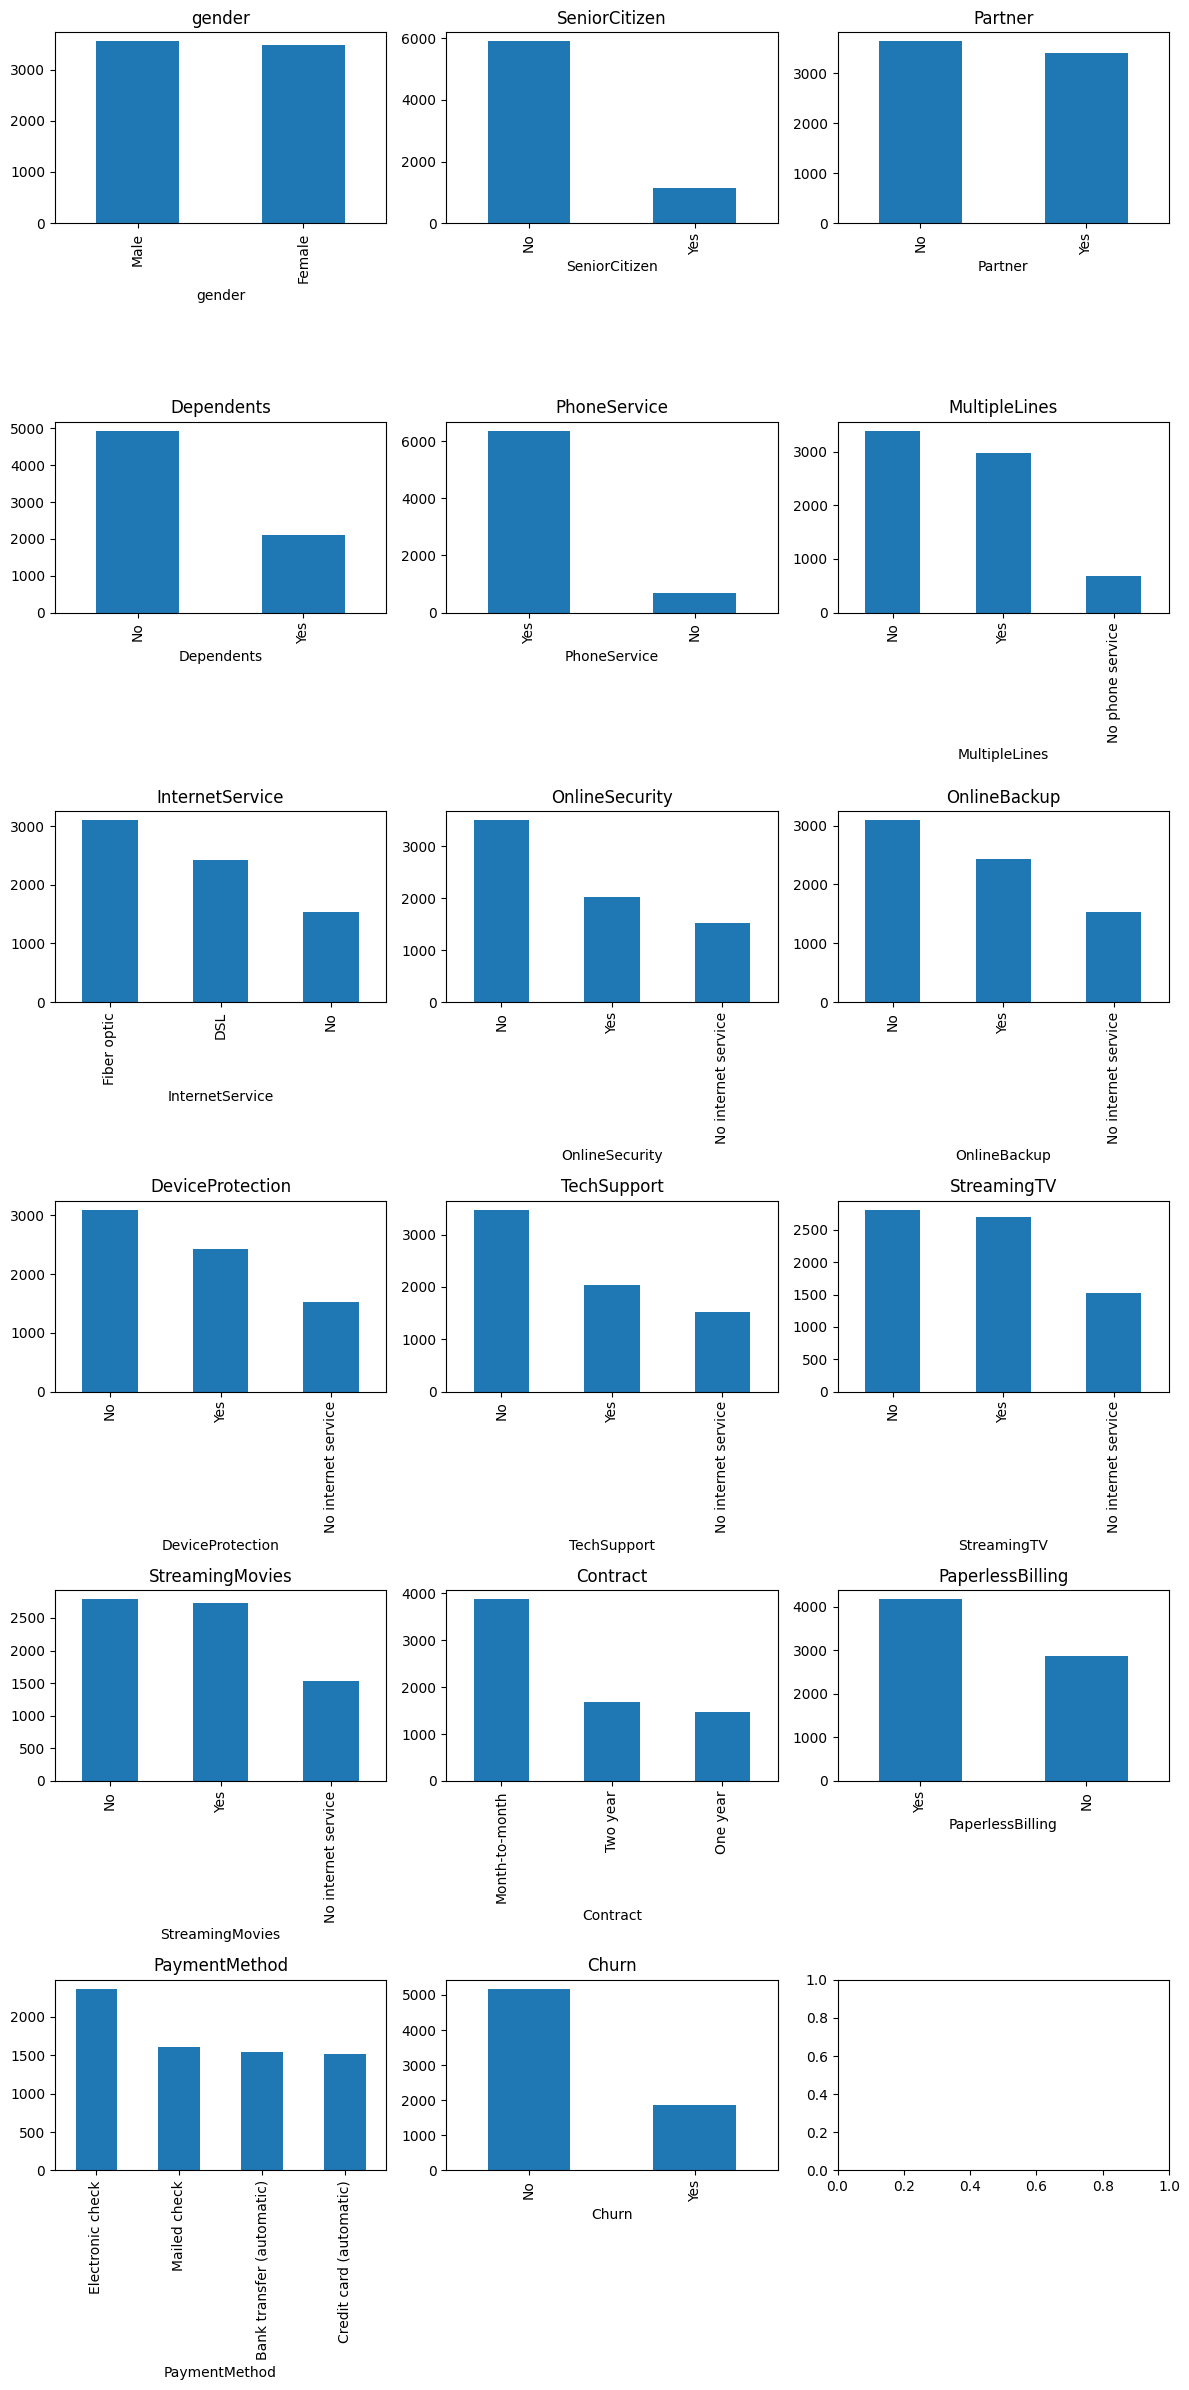

In [18]:
fig, axes=plt.subplots(6, 3, figsize=(12,24))
axes=axes.flatten()
for i, col in enumerate(categorical.columns):
    categorical[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()   
plt.show()

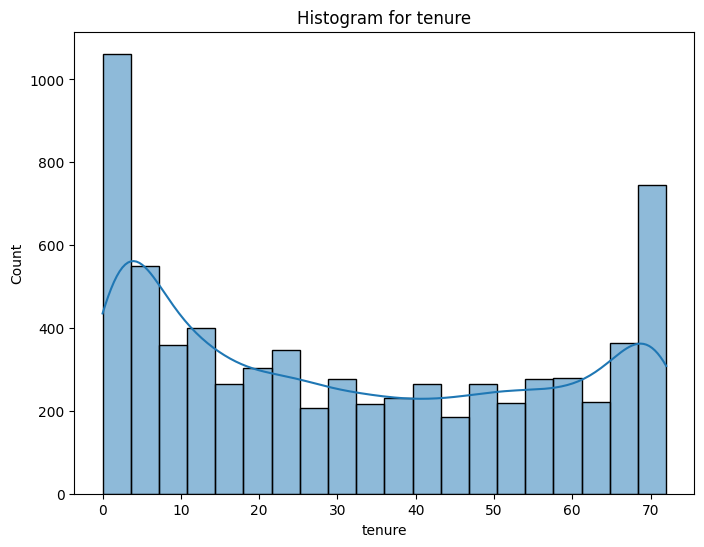

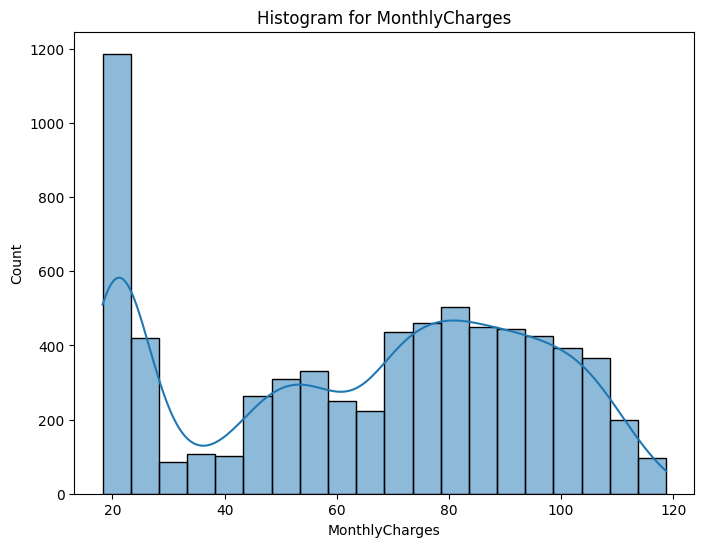

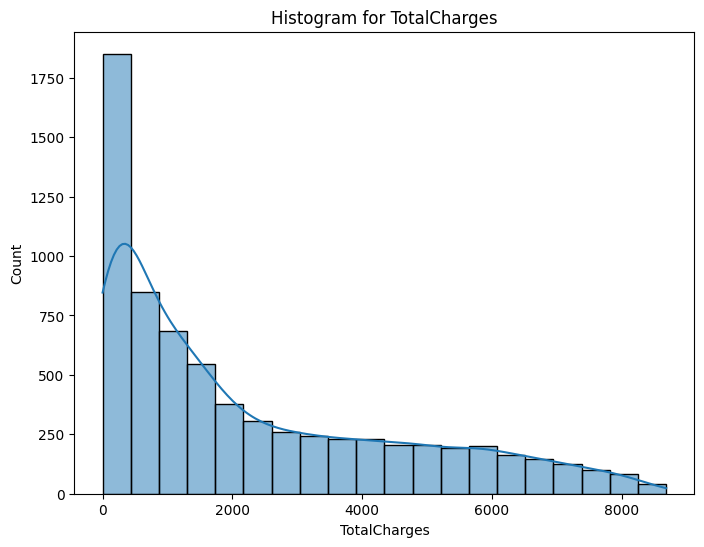

In [19]:
for col in numerical:
    plt.figure(figsize=(8, 6))
    sns.histplot(numerical[col], kde=True, bins=20)
    plt.title(f'Histogram for {col}')
    plt.show()

Test Normality using Shapiro-Wilk; I noticed that these numerical variables were skewed.

In [20]:
for col in numerical.columns:
    stat,p=shapiro(numerical[col])
    print(f'Column: {col}')
    print(f'Statistic={stat:.4f}, p-value={p:.4e}')
    print('-' * 40)


Column: tenure
Statistic=0.9037, p-value=7.5273e-55
----------------------------------------
Column: MonthlyCharges
Statistic=0.9209, p-value=2.2296e-51
----------------------------------------
Column: TotalCharges
Statistic=0.8602, p-value=8.9384e-62
----------------------------------------


/Users/michaelgriffin/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7043.
  res = hypotest_fun_out(*samples, **kwds)


Normalize numerical variables to address skewness and prep for dimensionality reduction and feature importance.

In [21]:
scaler=StandardScaler()
scaled_numerical=scaler.fit_transform(numerical)
scaled_numerical_df=pd.DataFrame(scaled_numerical, columns=['tenure','MonthlyCharges','TotalCharges'])

Export Cleaned Data to CSV for multivariate

In [22]:
churn.to_csv('cleaned.csv')

## Label Encoding Categorical Data (Test Run)

In [23]:
encoder=preprocessing.LabelEncoder()

for col in categorical:
    categorical[col]=encoder.fit_transform(categorical[col])

In [24]:
churn_labeled=pd.concat([categorical,scaled_numerical_df], axis=1)

In [25]:
churn_labeled.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0,-1.277445,-1.160323,-0.992611
1,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0,0.066327,-0.259629,-0.172165
2,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1,-1.236724,-0.362660,-0.958066
3,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0,0.514251,-0.746535,-0.193672
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1,-1.236724,0.197365,-0.938874


In [26]:
churn_labeled.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7.043000e+03,7.043000e+03,7.043000e+03
mean,0.504756,0.162147,0.483033,0.299588,0.903166,0.940508,0.872923,0.790004,0.906432,0.904444,0.797104,0.985376,0.992475,0.690473,0.592219,1.574329,0.265370,-2.421273e-17,-6.406285e-17,-3.783239e-17
std,0.500013,0.368612,0.499748,0.458110,0.295752,0.948554,0.737796,0.859848,0.880162,0.879949,0.861551,0.885002,0.885091,0.833755,0.491457,1.068104,0.441561,1.000071e+00,1.000071e+00,1.000071e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.318165e+00,-1.545860e+00,-1.005780e+00
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-9.516817e-01,-9.725399e-01,-8.299464e-01
50%,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,-1.372744e-01,1.857327e-01,-3.905282e-01
75%,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,9.214551e-01,8.338335e-01,6.648034e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.613701e+00,1.794352e+00,2.825806e+00


In [27]:
with open('encoded.pkl', 'wb') as file:
    pickle.dump(churn_labeled, file)


In [28]:
churn_labeled.to_csv('churn_labeled')

Identifying outliers using helper function

Using Variance Inflation Factor to determine collinearity between variables

            features        VIF
0             gender   1.948085
1      SeniorCitizen   1.348206
2            Partner   2.775115
3         Dependents   1.974204
4       PhoneService   9.430102
5      MultipleLines   2.457432
6    InternetService   4.107950
7     OnlineSecurity   2.277232
8       OnlineBackup   2.410761
9   DeviceProtection   2.591058
10       TechSupport   2.428897
11       StreamingTV   3.141766
12   StreamingMovies   3.145130
13          Contract   4.158709
14  PaperlessBilling   2.657545
15     PaymentMethod   3.478376
16             Churn   1.801762
17            tenure   7.439238
18    MonthlyCharges   4.835733
19      TotalCharges  10.574803


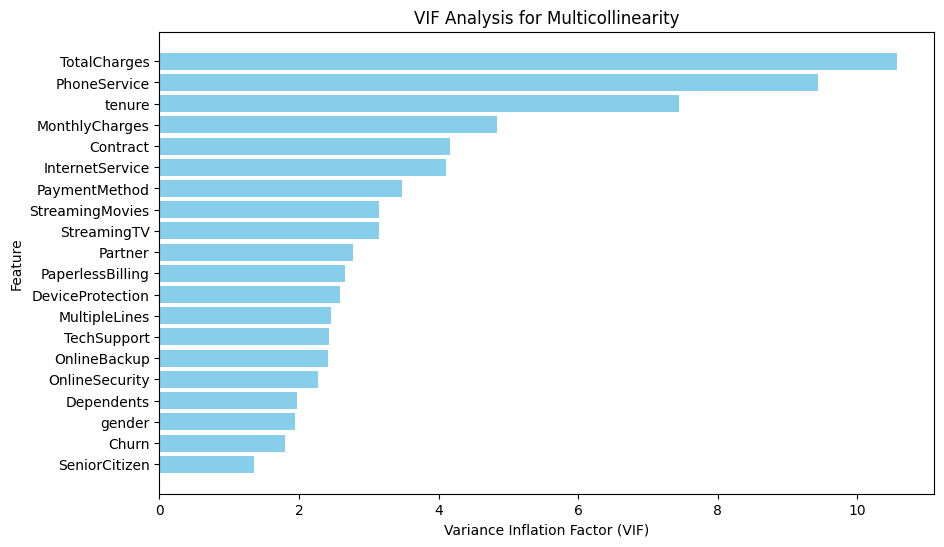

In [29]:
vif_data=pd.DataFrame()
vif_data['features']=churn_labeled.columns
vif_data['VIF']=[variance_inflation_factor(churn_labeled.values,i) for i in range(len(churn_labeled.columns))]
print(vif_data)

vif_data = vif_data.sort_values(by="VIF", ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(vif_data["features"], vif_data["VIF"], color="skyblue")
plt.xlabel("Variance Inflation Factor (VIF)")
plt.ylabel("Feature")
plt.title("VIF Analysis for Multicollinearity")
plt.gca().invert_yaxis()  
plt.show()

## Determining Feature Importance with ANOVA K-Best F-Statistic (Based upon a similar statistical concept as VIF, but not directly the same approach)

Move Target Column ('Churn') to first position

In [30]:
target=churn_labeled.pop('Churn')
churn_labeled.insert(0, 'Churn',target)

Feature 0: 1.323655
Feature 1: 115.843924
Feature 2: 113.274504
Feature 3: 133.622243
Feature 4: 2.523665
Feature 5: 6.984384
Feature 6: 11.845441
Feature 7: 494.945012
Feature 8: 231.257922
Feature 9: 180.746680
Feature 10: 463.200222
Feature 11: 9.890783
Feature 12: 5.716910
Feature 13: 1056.455417
Feature 14: 197.432607
Feature 15: 61.491201
Feature 16: 795.926576
Feature 17: 226.930003
Feature 18: 225.847236


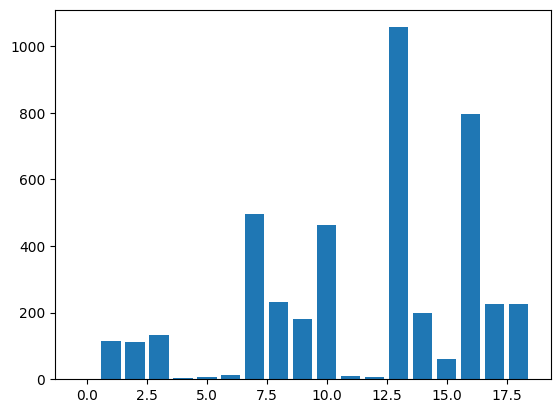

In [31]:
X=churn_labeled.iloc[:,1:]
y=churn_labeled.iloc[:,0]
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=.2, random_state=1)
feat_select=SelectKBest(score_func=f_classif, k='all')
feat_select.fit(X_train, y_train)
X_train_fs=feat_select.transform(X_train)
X_test_fs=feat_select.transform(X_test)
for i in range(len(feat_select.scores_)):
	print('Feature %d: %f' % (i, feat_select.scores_[i]))
#
plt.bar([i for i in range(len(feat_select.scores_))], feat_select.scores_)
plt.show()

## Our most import features according to F-Statistic are StreamingMovies and PaymentMethod